In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import sys
sys.path.insert(0,'..')


from dfibert.tracker.nn.rl import Agent
import dfibert.envs.RLTractEnvironment as RLTe
from dfibert.tracker import save_streamlines

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

# I. HCP Tracking
The environment is able to run tracking on a fixed set of datasets. At the moment, it is able to load HCP data as well as ISMRM data. The following cells shows the initalisation of our environment on HCP dataset `100307` while seed points are automatically determined at voxels with fa-value >= 0.2 via `seeds = None`.

In [2]:
env = RLTe.RLTractEnvironment(step_width=0.8, dataset = '100307',
                              device = 'cpu', seeds = None, tracking_in_RAS = False,
                              odf_state = False, odf_mode = "DTI")

Loading dataset #  100307
Initialising ODF
DTI-based ODF computation


In [ ]:
streamlines = env.track()

We can also directly visualize our streamlines in this notebook by `ax.plot3d`. However, a single streamline is typically very hard to comprehend so this is merely one tool to qualitatively reason about major bugs in our tracking code.

In [9]:
%matplotlib notebook
streamline_index = 9
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

<IPython.core.display.Javascript object>

# II. Evaluation of Cortico Spinal Tract @ ISMRM benchmark data
We will now be using our environment along with our reward function to track streamlines on the ISMRM dataset. For this purpose, we first initialise our environment and set seed points to the cortico spinal tract. We precomputed seed points in IJK for our ISMRM dataset. These seeds will now be loaded into our environment.

In [3]:
seeds_CST = np.load('data/ismrm_seeds_CST.npy')
seeds_CST = torch.from_numpy(seeds_CST)

In [4]:
env = RLTe.RLTractEnvironment(dataset = 'ISMRM', max_angle = 80., step_width=0.8,
                            device = 'cpu', seeds = seeds_CST, action_space=70,
                              tracking_in_RAS = False, odf_state = False, odf_mode = "DTI")

Loading dataset #  ISMRM


/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


In [19]:
env._init_odf()

Initialising ODF
DTI-based ODF computation


In [10]:
env.interpolate_odf_at_state(env.state.getCoordinate()).shape

Initialising ODF
DTI-based ODF computation


(20, 3, 3, 3)

In [15]:
env.odf_interpolator((30,30,30))

array([0.08620227, 0.08375269, 0.07609844, 0.07802908, 0.10176904,
       0.08935699, 0.07630523, 0.07118411, 0.06722387, 0.07293464,
       0.08620227, 0.08375269, 0.07609844, 0.07802908, 0.10176904,
       0.08935699, 0.07630523, 0.07118411, 0.06722387, 0.07293464])

Tracking itself can now be done by basically calling the `.track()` function that tracks our streamlines from each of the provided seed points in a forward and backward direciton.

In [4]:
streamlines = env.track()

  0%|          | 0/5701 [00:00<?, ?it/s]

Initialising ODF
DTI-based ODF computation


../dfibert/envs/RLTractEnvironment.py:310: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  peak_indices = peaks[peak_mask[peaks].nonzero()]
  2%|▏         | 112/5701 [00:07<07:43, 12.06it/s] ../dfibert/envs/RLTractEnvironment.py:278: RuntimeWarning: invalid value encountered in true_divide
  reward = pmf_cur / np.max(pmf_cur)
100%|██████████| 5701/5701 [05:50<00:00, 16.29it/s]


The streamlines are now stored as VTK file. The nice thing about this format is that we can directly import the streamlines into 3dSlicer via the slicer-dMRI extension.

In [7]:
streamlines_ras = [env.dataset.to_ras(sl) for sl in streamlines]

In [8]:
save_streamlines(streamlines=streamlines_ras, path="ismrm_cst2_ras_70actions_hemi.vtk")

# Peaks from odf

In [5]:
cur_position = env.state.getCoordinate().view(-1, 3)
odf_cur = torch.from_numpy(env.interpolate_odf_at_state(stateCoordinates=cur_position))[:, 1, 1, 1].view(env.directions_odf.shape[0])
print(odf_cur)
reward = odf_cur / torch.max(odf_cur)
print(reward)

Initialising ODF
DTI-based ODF computation
tensor([0.0998, 0.0758, 0.0715, 0.0746, 0.0888, 0.0730, 0.0643, 0.0735, 0.0698,
        0.0716, 0.0900, 0.0881, 0.0654, 0.0638, 0.1086, 0.0731, 0.1042, 0.0650,
        0.0757, 0.0832, 0.0659, 0.0727, 0.0883, 0.0710, 0.0823, 0.0736, 0.1093,
        0.0754, 0.0699, 0.1022, 0.0684, 0.0896, 0.0903, 0.0838, 0.0636],
       dtype=torch.float64)
tensor([0.9132, 0.6939, 0.6540, 0.6823, 0.8128, 0.6680, 0.5886, 0.6728, 0.6382,
        0.6551, 0.8231, 0.8065, 0.5979, 0.5835, 0.9937, 0.6692, 0.9529, 0.5948,
        0.6924, 0.7615, 0.6033, 0.6647, 0.8079, 0.6496, 0.7525, 0.6735, 1.0000,
        0.6897, 0.6394, 0.9347, 0.6255, 0.8200, 0.8259, 0.7670, 0.5823],
       dtype=torch.float64)


In [2]:
%matplotlib inline

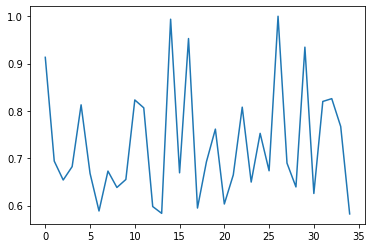

In [8]:
plt.plot(reward)

tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0], dtype=torch.uint8)


<IPython.core.display.Javascript object>


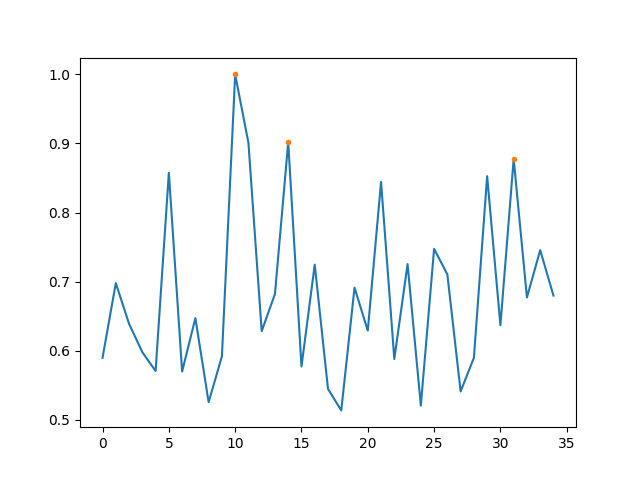

In [14]:
N = 100
width = 31 # odd
#reward -= torch.linspace(0, reward[-1].item(), reward.size(0))
odf_diff = ((reward[:-2]<reward[1:-1]) & (reward[2:]<reward[1:-1])).type(torch.uint8) 
peak_mask =  torch.cat([torch.zeros(1, dtype=torch.uint8), odf_diff, torch.zeros(1, dtype=torch.uint8)], dim=0)
print(peak_mask)
b = torch.nn.functional.max_pool1d_with_indices(reward.view(1,1,-1), width, 1, padding=width//2)[1].unique()
b = b[peak_mask[b].nonzero()]

plt.plot(reward.numpy())
plt.plot(b.numpy(), reward[b].numpy(),'.')

In [45]:
env.directions_odf[b].squeeze(1)

tensor([[-0.0580, -0.7233,  0.6880],
        [ 0.5262, -0.5466,  0.6515],
        [ 0.2752, -0.7925,  0.5443],
        [ 0.5674, -0.7555,  0.3276],
        [ 0.2437, -0.9505,  0.1927],
        [-0.5143,  0.8570,  0.0323],
        [-0.2752,  0.7925, -0.5443],
        [-0.5674,  0.7555, -0.3276],
        [-0.2437,  0.9505, -0.1927]], dtype=torch.float64)

In [62]:
cos_similarities = torch.nn.functional.cosine_similarity(env.directions, env.directions_odf[b], dim=-1)

In [48]:
cos_similarities.shape

torch.Size([9, 30])

In [76]:
_max = torch.max(cos_similarities, dim=0)[0]
print(_max)

tensor([0.5091, 0.9087, 0.8389, 0.9837, 0.8301, 0.6892, 0.6855, 0.6499, 0.9993,
        0.9908, 0.7874, 0.8389, 0.4858, 0.6803, 0.4766, 0.4870, 0.8383, 0.5243,
        0.5358, 0.7916, 0.9577, 0.3958, 0.9317, 0.9811, 0.8598, 0.9506, 0.8181,
        0.9822, 0.6018, 0.4066], dtype=torch.float64)


In [77]:
best_action = np.argmax(_max)
print(best_action)

tensor(8)


# Spheres

In [7]:
from dipy.core.sphere import HemiSphere, Sphere
from dipy.core.sphere import disperse_charges
phi = np.pi * np.random.rand(50)#np.linspace(0, np.pi, num=52)#
theta = 2 * np.pi * np.random.rand(50)#np.linspace(0, 2*np.pi, num=52)#
hemi_sphere = HemiSphere(theta=theta, phi=phi)
hemi_sphere, _ = disperse_charges(hemi_sphere, 5000)

In [9]:
hemi_sphere.vertices.shape

(50, 3)

In [8]:
sphere_m = Sphere(xyz=np.vstack((hemi_sphere.vertices, -hemi_sphere.vertices)))

In [1]:
%matplotlib inline

In [11]:
ax = plt.axes(projection='3d')
ax.scatter(sphere.vertices.T[0], sphere.vertices.T[1], sphere.vertices.T[2])
ax.scatter(sphere_m.vertices.T[0], sphere_m.vertices.T[1], sphere_m.vertices.T[2])

In [9]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion100')

# Reinforcement Learning
## DQN

WIP code !!! 

In [3]:
# init env
seeds_CST = np.load('data/ismrm_seeds_CST.npy')
seeds_CST = torch.from_numpy(seeds_CST)
env = RLTe.RLTractEnvironment(dataset = 'ISMRM', max_angle = 80., step_width=0.8,
                            device = 'cpu', seeds = seeds_CST, action_space=20,
                              tracking_in_RAS = False, odf_state = False, odf_mode = "DTI")

Loading dataset #  ISMRM


/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


In [4]:
from dfibert.tracker.nn.rainbow_agent import DQNAgent

In [5]:
# Hyperparameters:
replay_memory_size = 100000
batch_size = 128
target_update = 1000
gamma = 0.99
max_steps = 60000000

path = './training_test'

In [6]:
agent = DQNAgent(env=env, memory_size = replay_memory_size,
        batch_size = batch_size,
        target_update = target_update,
        gamma = gamma)

cuda


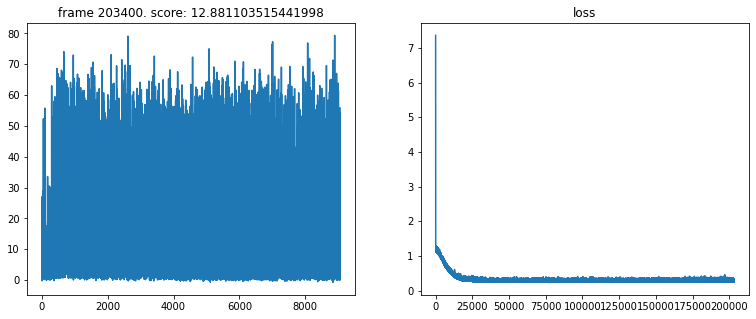

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-4e908dba86a4>", line 1, in <module>
    agent.train(num_frames = max_frames, path = path)
  File "../dfibert/tracker/nn/rainbow_agent.py", line 608, in train
    loss = self.update_model()
  File "../dfibert/tracker/nn/rainbow_agent.py", line 564, in update_model
    self.optimizer.step()
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/torch/autograd/grad_mode.py", line 26, in decorate_context
    return func(*args, **kwargs)
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/torch/optim/adam.py", line 108, in step
    F.adam(params_with_grad,
  File "/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/torch/optim/functional.py", line 86, in adam
    exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
Keyboard

KeyboardInterrupt: 

In [7]:
agent.train(num_frames = max_steps, path = path)

In [ ]:
streamline_index = 0
device = "cpu"
max_steps = 30000000
replay_memory_size = 100000
agent_history_length = 1
evaluate_every = 200000
eval_runs = 5#20
network_update_every = 10000
start_learning = 10000
eps_annealing_steps = 400000

max_episode_length = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 512
learning_rate = 0.000001 


state = env.reset(seed_index=streamline_index)
env.referenceStreamline_ijk, state.getCoordinate()

In [ ]:
agent = Agent(n_actions=100, inp_size=state.getValue().shape, device=device, hidden=10, gamma=0.99, 
              agent_history_length=agent_history_length, 
              memory_size=replay_memory_size, batch_size=batch_size, learning_rate=learning_rate)

## Fill replay memory 
The replay memory consists of perfect actions for supervised pre-training of our agent. This allows us to take leverage on knowledge and significantly speedup convergence of the training.

In [ ]:

from tqdm import trange
state = env.reset().getValue()

overall_runs = 0
overall_reward = []
for overall_runs in trange(600):
    state = env.reset(seed_index=overall_runs)
    #episode_step_counter = 0
    episode_reward = 0
    terminal = False
    current_direction = None
    #print("New run")
    #print(env.stepCounter, state.getCoordinate().numpy())
    while not terminal:
        my_position = state.getCoordinate().double().squeeze(0)
        #print(env.stepCounter)
        #if np.random.rand(1) < 0.1: 
        #    action = np.random.randint(0, n_actions)
        #else:
        
        # current position
        my_position = state.getCoordinate().double().squeeze(0)
        
        action = env._get_best_action(current_direction, my_position)

        current_direction = env.directions[action].numpy()
        
        next_state, reward, terminal, _ = env.step(action)
        print("Reward: ", reward)
        agent.replay_memory.add_experience(action=action,
                                state = state.getValue(),
                                reward=reward,
                                new_state = next_state.getValue(),
                                terminal=terminal)
        
        episode_reward += reward
        
        state = next_state
        
        if terminal == True:
            break
            
    overall_runs += 1
    overall_reward.append(episode_reward)
    print(overall_runs, np.mean(overall_reward[-100:]))
print("Replay memory ready")

In the following cell, we are testing the accuracy of our agent right after initialisation. 

In [ ]:
states, actions, _, _, _ = agent.replay_memory.get_minibatch()
states = torch.FloatTensor(states).to(agent.device)
predicted_q = torch.argmax(agent.main_dqn(states), dim=1)

false = 0
for i in range(len(actions)):
    if predicted_q[i] != actions[i]:
        false += 1 
    
print("Accuracy =", 1 - false / len(actions))

In [ ]:
step_counter = 0
eps_rewards = []
episode_lengths = []

eps = 1.0

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        episode_reward_sum = 0
        terminal = False
        episode_step_counter = 0
        positive_run = 0
        points_visited = 0
        
        negative_rewards = 0
        
        
        # reduce epsilon
        if step_counter > start_learning:
            eps = max(eps * 0.999, 0.01)
        
        # play an episode
        while episode_step_counter <= 1000.:
            
            # get an action with epsilon-greedy strategy
            if random.random() < eps:                                 
                action = np.random.randint(env.action_space.n)           # either random action
                #action = env._get_best_action(current_direction, my_position)
            else:                                                        # or action from agent
                agent.main_dqn.eval()
                with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                agent.main_dqn.train()
            
            # perform step on environment
            next_state, reward, terminal, _ = env.step(action)

            
            episode_step_counter += 1
            step_counter += 1
            epoch_step += 1
            
            episode_reward_sum += reward
            
            # store experience in replay buffer
            agent.replay_memory.add_experience(action=action, state = state.getValue(), reward=reward, new_state = next_state.getValue(), terminal=terminal)
            
            state = next_state
            
            # optimize agent after certain amount of steps
            if step_counter > start_learning and step_counter % 4 == 0:
                
                # original optimization function
                #agent.optimize()
                
                ### debugging optimization function
                
                states, actions, rewards, new_states, terminal_flags = agent.replay_memory.get_minibatch()
                
                #states = torch.tensor(states)#.view(replay_memory.batch_size, -1) # 1, -1
                #next_states = torch.tensor(new_states)#.view(replay_memory.batch_size, -1)
                #actions = torch.LongTensor(actions)
                #rewards = torch.tensor(rewards)
                #terminal_flags = torch.BoolTensor(terminal_flags)

                states = torch.from_numpy(states).to(device)
                next_states = torch.from_numpy(new_states).to(device)
                actions = torch.from_numpy(actions).unsqueeze(1).long().to(device)
                rewards = torch.from_numpy(rewards).to(device)
                terminal_flags = torch.from_numpy(terminal_flags).to(device)
                
                
                state_action_values = agent.main_dqn(states).gather(1, actions).squeeze(-1)
                next_state_actions = torch.argmax(agent.main_dqn(next_states), dim=1)
                next_state_values = agent.target_dqn(next_states).gather(1, next_state_actions.unsqueeze(-1)).squeeze(-1)
                #
                next_state_values[terminal_flags] = 0.0
                #
                expected_state_action_values = next_state_values.detach() * 0.9995 + rewards
                #
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
                agent.optimizer.zero_grad()
                loss.backward()
                agent.optimizer.step()
                
            # update target network after certain amount of steps    
            if step_counter > start_learning and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if epsiode has ended, step out of the episode while loop
            if terminal:
                break
                
        # keep track of past episode rewards
        eps_rewards.append(episode_reward_sum)
        if len(eps_rewards) % 20 == 0:
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), eps))#action_scheduler.eps_current))

            
    ##########################
    ##########################
    ## evaluation#############
    ##########################
    ##########################
    eval_rewards = []
    episode_final = 0
    agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        
        eval_episode_reward = 0
        negative_rewards = 0
        
        # play an episode
        while eval_steps < 1000:
            # get the action from the agent
            with torch.no_grad():
                    state_v = torch.from_numpy(state.getValue()).unsqueeze(0).float().to(device)
                    action = torch.argmax(agent.main_dqn(state_v)).item()
                  
            # perform a step on the environment
            next_state, reward, terminal, _ = env.step(action)
            
            eval_steps += 1
            
            eval_episode_reward += reward
            state = next_state
            
            # step out of the episode while loop if 
            if terminal:
                terminal = False
                if reward == 1.:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))